# Wind Turbine Data Set: Exploratory Visualizations

1. [Imports.](#Cell1)
1. [Read in training data set and histogram target variable.](#Cell2)
1. [Check if some turbines share wind measurements.](#Cell3)
1. [Examine autocorrelation of turbine output.](#Cell4)
1. [Make scatter plots of a given turbine output versus all horizontal wind speed measurements at 10m above ground.](#Cell5)
1. [Plot turbine output and wind speed as a function of time.](#Cell6)
1. [Plot turbine outputs as a function of time.](#Cell6b)
1. [Plot zero-output events as a function of the day of the year.](#Cell7)
1. [Compute matrix of correlation plots between select features and target variable.](#Cell8)
1. [Compare feature distributions for zero and non-zero turbine output.](#Cell9)
1. [Plot meridional versus zonal wind velocities, separating instances with zero and non-zero turbine output.](#Cell10)
1. [Compare horizontal wind velocity distributions for zero and non-zero turbine output.](#Cell11)

<a id='Cell1'></a>

In [1]:
'''
Imports
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline

<a id='Cell2'></a>


Rates of zero turbine output: 
{1: 1381, 2: 337, 3: 886, 4: 628, 5: 1107, 6: 1110, 7: 1222, 8: 1562, 9: 2361, 10: 1140}

Number of turbine output measurements equal to 0:       11734
Number of turbine output measurements equal to 1:           7
Number of turbine output measurements between 0 and 1: 126969
Total number of turbine output measurements:           138710


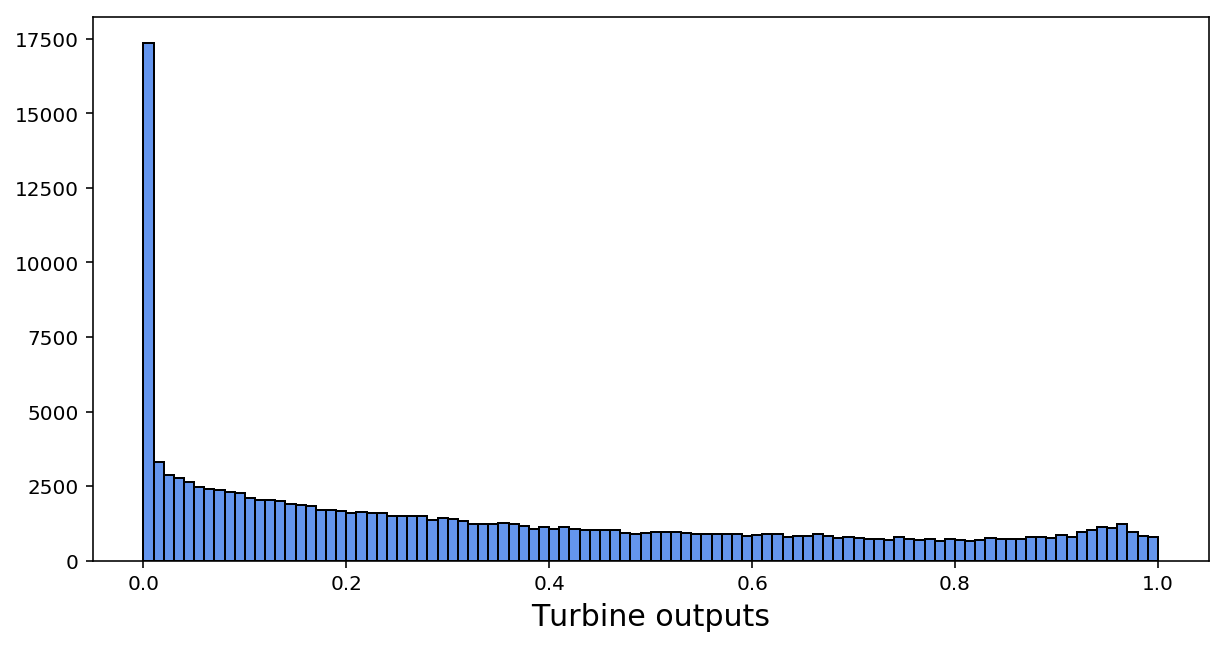

In [24]:
'''
Read in training data set and histogram target variable.
'''
%config InlineBackend.figure_format = 'retina'

rmws = 4 # Set size of rolling means window

if rmws<=1:
    rm = ""
    TrainingDataFile = "data/Train_pp_2017_02_27_18_37_05.pkl"
elif rmws==2:
    rm = "_rm2"
    TrainingDataFile = "data/Train_pp_2017_03_11_22_52_56.pkl"
elif rmws==3:
    rm = "_rm3"
    TrainingDataFile = "data/Train_pp_2017_03_10_15_37_41.pkl"
elif rmws==4:
    rm = "_rm4"
    TrainingDataFile = "data/Train_pp_2017_03_11_02_06_50.pkl"
else:
    print("Invalid rolling mean window size: {0}".format(rmws))
    
U10  = "U10"+rm
U100 = "U100"+rm
V10  = "V10"+rm
V100 = "V100"+rm

df = pd.read_pickle(TrainingDataFile)

# Add columns with horizontal speed magnitudes and meteorological directions
nturbines = 10
for i in range(1,nturbines+1):
    df[('H10',i)]  = np.sqrt(df[(U10,i)]**2 + df[(V10,i)]**2)
    df[('H100',i)] = np.sqrt(df[(U100,i)]**2 + df[(V100,i)]**2)
    df[('A10',i)]  = np.rad2deg(np.arctan2(-df[(U10,i)], -df[(V10,i)]))
    df[('A100',i)] = np.rad2deg(np.arctan2(-df[(U100,i)], -df[(V100,i)]))

# Count turbine outputs that are zero, one, or in between.
zeroes    = {i: len(df[df[('TARGETVAR',i)]==0]) for i in range(1,nturbines+1)}
inbetween = {i: len(df[(df[('TARGETVAR',i)]>0) & (df[('TARGETVAR',i)]<1)])  for i in range(1,nturbines+1)}
ones      = {i: len(df[df[('TARGETVAR',i)]==1]) for i in range(1,nturbines+1)}
print('\nRates of zero turbine output: \n{0}\n'.format(zeroes))
print('Number of turbine output measurements equal to 0:      {0:6d}'.format(sum(zeroes.values())))
print('Number of turbine output measurements equal to 1:      {0:6d}'.format(sum(ones.values())))
print('Number of turbine output measurements between 0 and 1: {0:6d}'.format(sum(inbetween.values())))
print('Total number of turbine output measurements:           {0:6d}'.format(nturbines*len(df)))

# Plot histogram of turbine output, summed over all turbines
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(10,5) )
targets = []
for turbine in range(1,nturbines+1):
    targets.extend(df[('TARGETVAR',turbine)].tolist())
axes.hist(targets, bins=100, range=None, normed=False, histtype='bar', align='mid', 
          orientation='vertical', log=False, color='cornflowerblue', edgecolor='k', label=None)
axes.set_xlabel("Turbine outputs", fontsize=15)
plt.show()
fig.savefig('wind_turbine_outputs.png', dpi=200, bbox_inches='tight')

<a id='Cell3'></a>

In [3]:
'''
Check if some turbines share wind measurements.
'''
for i in range(1,nturbines):
    for j in range(i+1,nturbines+1):
        if df[('U10',i)].equals(df[('U10',j)]):
            print('Turbines {0} and {1} share U10 measurements'.format(i,j))
        if df[('V10',i)].equals(df[('V10',j)]):
            print('Turbines {0} and {1} share V10 measurements'.format(i,j))
        if df[('U100',i)].equals(df[('U100',j)]):
            print('Turbines {0} and {1} share U100 measurements'.format(i,j))
        if df[('V100',i)].equals(df[('V100',j)]):
            print('Turbines {0} and {1} share V100 measurements'.format(i,j))

Turbines 4 and 5 share U10 measurements
Turbines 4 and 5 share V10 measurements
Turbines 4 and 5 share U100 measurements
Turbines 4 and 5 share V100 measurements
Turbines 7 and 8 share U10 measurements
Turbines 7 and 8 share V10 measurements
Turbines 7 and 8 share U100 measurements
Turbines 7 and 8 share V100 measurements


<a id='Cell4'></a>

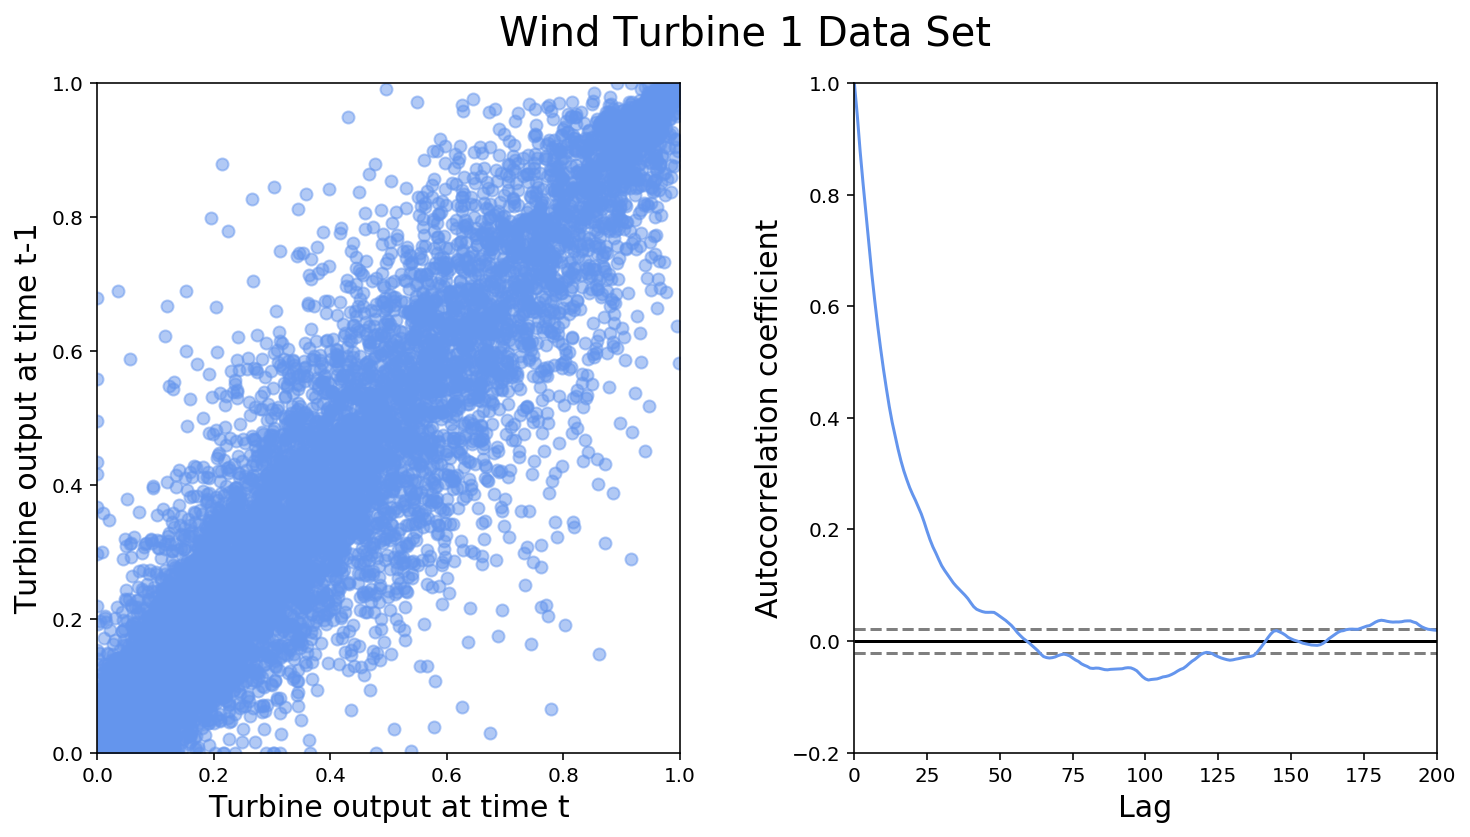

In [65]:
'''
Examine autocorrelation of turbine output.
See https://en.wikipedia.org/wiki/Correlogram
'''

turbine = 1

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
plt.subplots_adjust( wspace=0.30, hspace=0.20, top=0.90 )
plt.suptitle("Wind Turbine "+str(turbine)+" Data Set", fontsize=20)

series0 = df[('TARGETVAR',turbine)]
axes[0].scatter(series0, series0.shift(periods=1), color="cornflowerblue", alpha=0.5)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.0])
axes[0].set_xlabel("Turbine output at time t", fontsize=15)
axes[0].set_ylabel("Turbine output at time t-1", fontsize=15)

nmax = len(series0)
lags = range(0, nmax)
ci95 = 1.96/np.sqrt(float(nmax))
ci99 = 2.58/np.sqrt(float(nmax))
data = np.asarray(series0[:nmax])
c0   = np.var(data, ddof=0)
a1   = np.mean(data)
correlations = [((data[:nmax-k]-a1)*(data[k:]-a1)).sum()/float(nmax)/c0 for k in lags]
axes[1].plot(lags, correlations, color="cornflowerblue")
axes[1].hlines(y=0.0, xmin=0.0, xmax=200.0, color='k')
#axes[1].hlines(y=ci95,  xmin=0.0, xmax=200.0, color='k', alpha=0.5)
#axes[1].hlines(y=-ci95, xmin=0.0, xmax=200.0, color='k', alpha=0.5)
axes[1].hlines(y=ci99,  xmin=0.0, xmax=200.0, colors='k', linestyles='dashed', alpha=0.5)
axes[1].hlines(y=-ci99, xmin=0.0, xmax=200.0, colors='k', linestyles='dashed', alpha=0.5)
axes[1].set_xlim([0.0, 200.0])
axes[1].set_ylim([-0.20, +1.0])
axes[1].set_xlabel("Lag", fontsize=15)
axes[1].set_ylabel("Autocorrelation coefficient", fontsize=15)

plt.show()
fig.savefig('autocorrelations.png', dpi=200, bbox_inches='tight')

<a id='Cell5'></a>

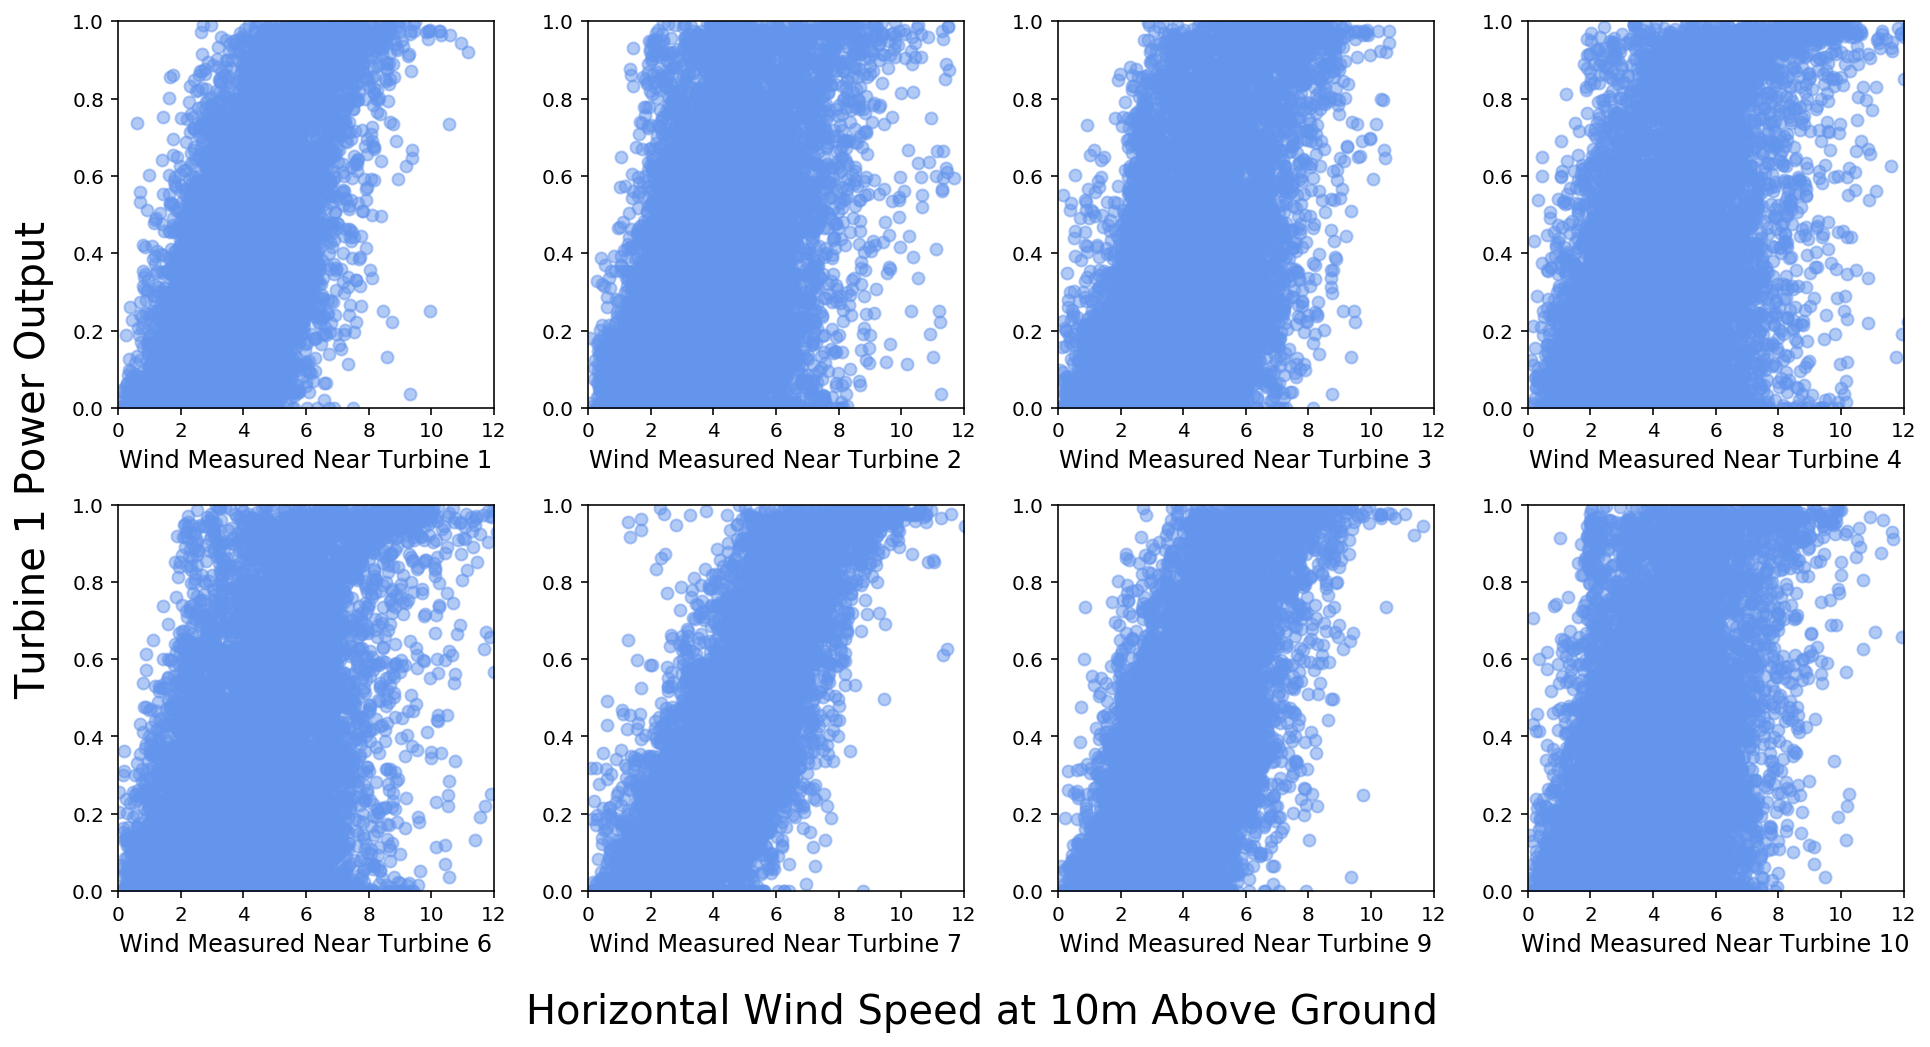

In [25]:
'''
Make scatter plots of a given turbine output versus all horizontal wind speed measurements at 10m above ground.
'''
turbine = 1

fig, axes = plt.subplots( nrows=2, ncols=4, figsize=(16,8) )
plt.subplots_adjust( wspace=0.25, hspace=0.25)
tcol   = "cornflowerblue"
alphas = 0.50
xmax   = 12.0

for ind,tnum in enumerate([1,2,3,4]):
    axes[0,ind].scatter(df[('H10', tnum)], df[('TARGETVAR', turbine)], color=tcol, alpha=alphas, marker="o")
    axes[0,ind].set_xlabel('Wind Measured Near Turbine '+str(tnum), fontsize=12)
    axes[0,ind].set_xlim(0.0, xmax)
    axes[0,ind].set_ylim(0.0, 1.0)
for ind,tnum in enumerate([6,7,9,10]):
    axes[1,ind].scatter(df[('H10', tnum)], df[('TARGETVAR', turbine)], color=tcol, alpha=alphas, marker="o")
    axes[1,ind].set_xlabel('Wind Measured Near Turbine '+str(tnum), fontsize=12)
    axes[1,ind].set_xlim(0.0, xmax)
    axes[1,ind].set_ylim(0.0, 1.0)
    
fig.text(0.08, 0.5, 'Turbine '+str(turbine)+' Power Output', va='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.01, 'Horizontal Wind Speed at 10m Above Ground', ha='center', fontsize=20)

plt.show()
fig.savefig('power_vs_windspeed.png', dpi=200, bbox_inches='tight')

<a id='Cell6'></a>

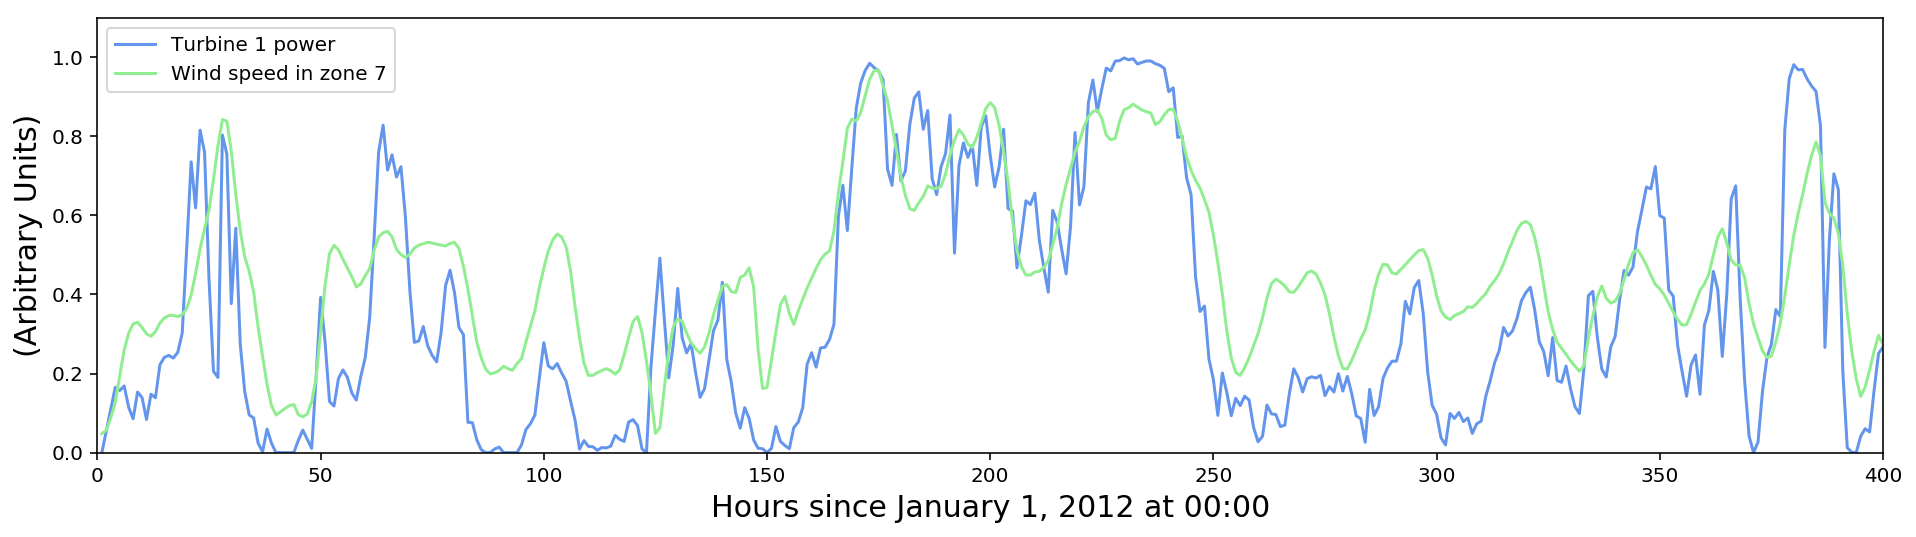

In [26]:
'''
Plot turbine output and wind speed as a function of time.
'''
tpower = 1
twind  = 7
npts   = 400

def make_time_stamp(row):
    return ((row['YEAR']-2012)*366 + (row['DAYOFYEAR']-1))*24 + row['HOUR']

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(16,4))
xval = df.iloc[:npts,:].apply(make_time_stamp, axis=1)
yval = df.loc[:npts-1,('TARGETVAR',tpower)]
zval = df.loc[:npts-1,('H10', twind)]/10

axis.plot(xval, yval, color="cornflowerblue", alpha=1.0, label="Turbine "+str(tpower)+" power")
axis.plot(xval, zval, color="lightgreen", alpha=1.0, label="Wind speed in zone "+str(twind))
axis.set_xlim([0., npts])
axis.set_ylim([0., 1.1])
axis.set_xlabel("Hours since January 1, 2012 at 00:00", fontsize=15)
axis.set_ylabel("(Arbitrary Units)", fontsize=15)
axis.legend(prop={'size': 10},loc="upper left")

plt.show()
fig.savefig('power_wind_vs_time.png', dpi=200, bbox_inches='tight')

<a id='Cell6b'></a>

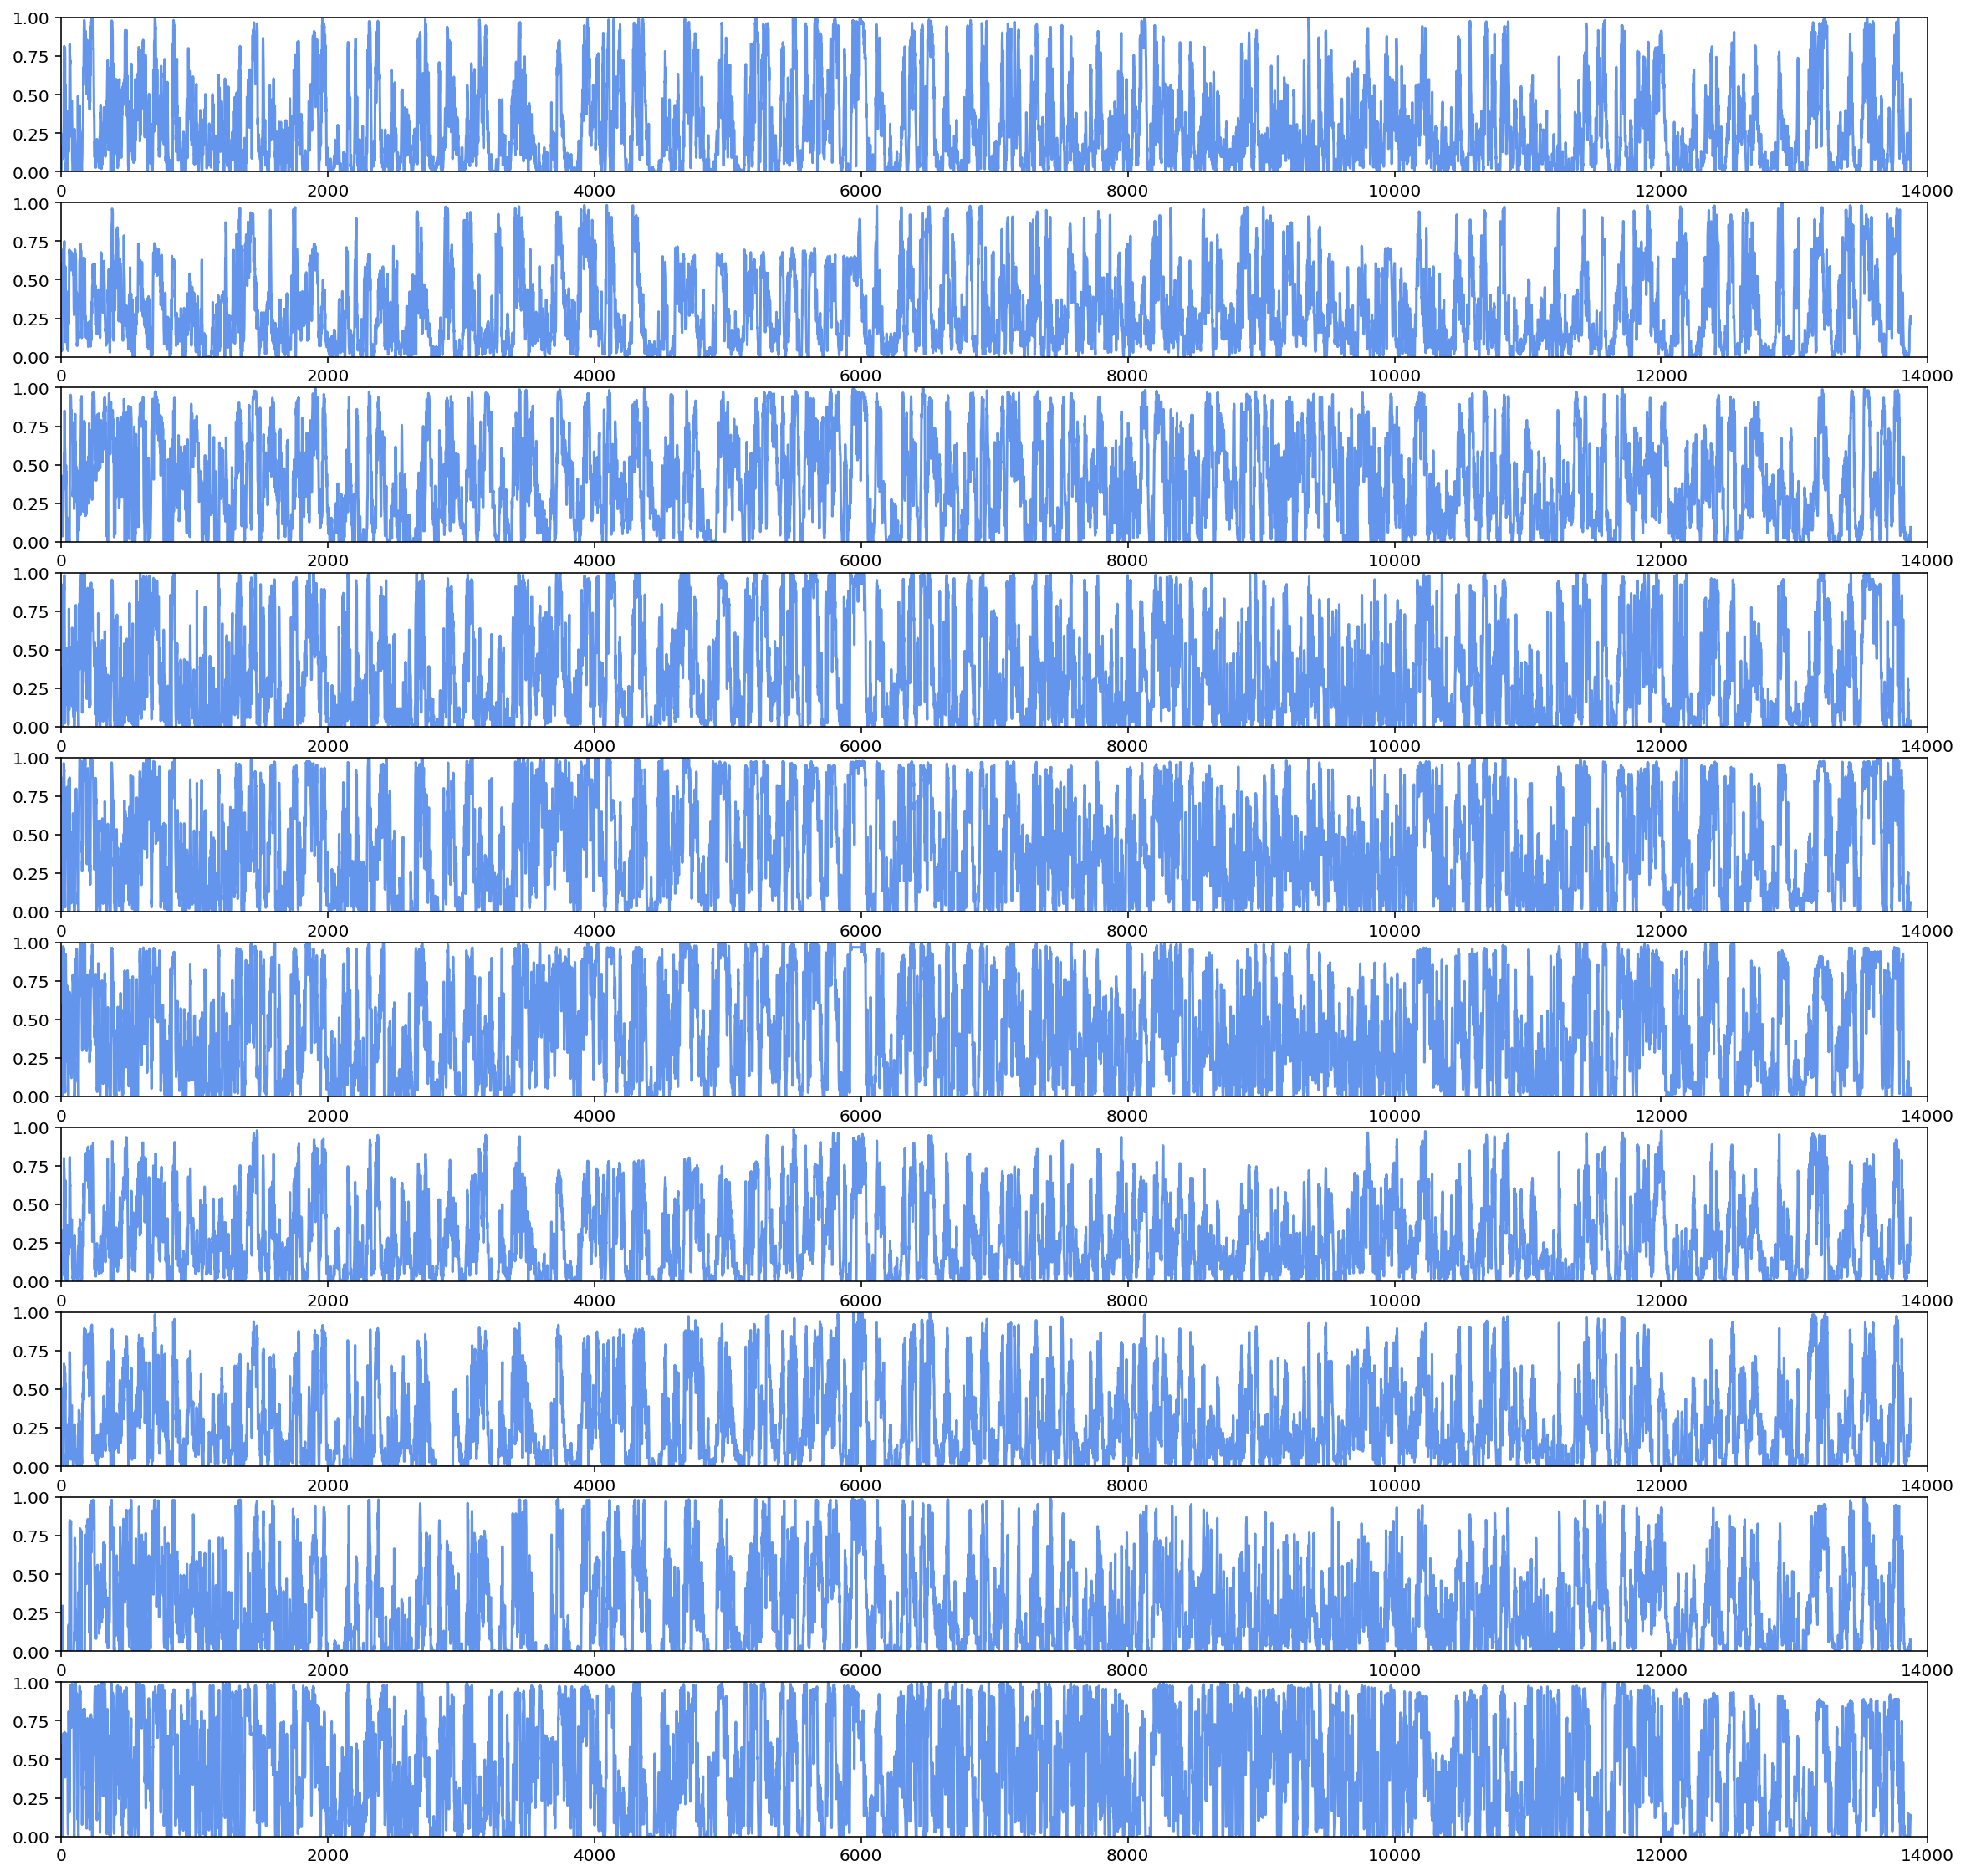

In [6]:
'''
Plot turbine outputs as a function of time.
'''
def make_time_stamp(row):
    return ((row['YEAR']-2012)*366 + (row['DAYOFYEAR']-1))*24 + row['HOUR']

fig, axes = plt.subplots( nrows=10, ncols=1, figsize=(20,20))
for turbine in range(1,nturbines+1):
    xval = df.apply(make_time_stamp, axis=1 )
    yval = df[('TARGETVAR',turbine)]
    axes[turbine-1].plot(xval, yval, color="cornflowerblue", alpha=1.0)
    axes[turbine-1].set_xlim([1., 14000.])
    axes[turbine-1].set_ylim([0., 1.])
axes[0].set_xlabel("Time", fontsize=15)

plt.show()

<a id='Cell7'></a>

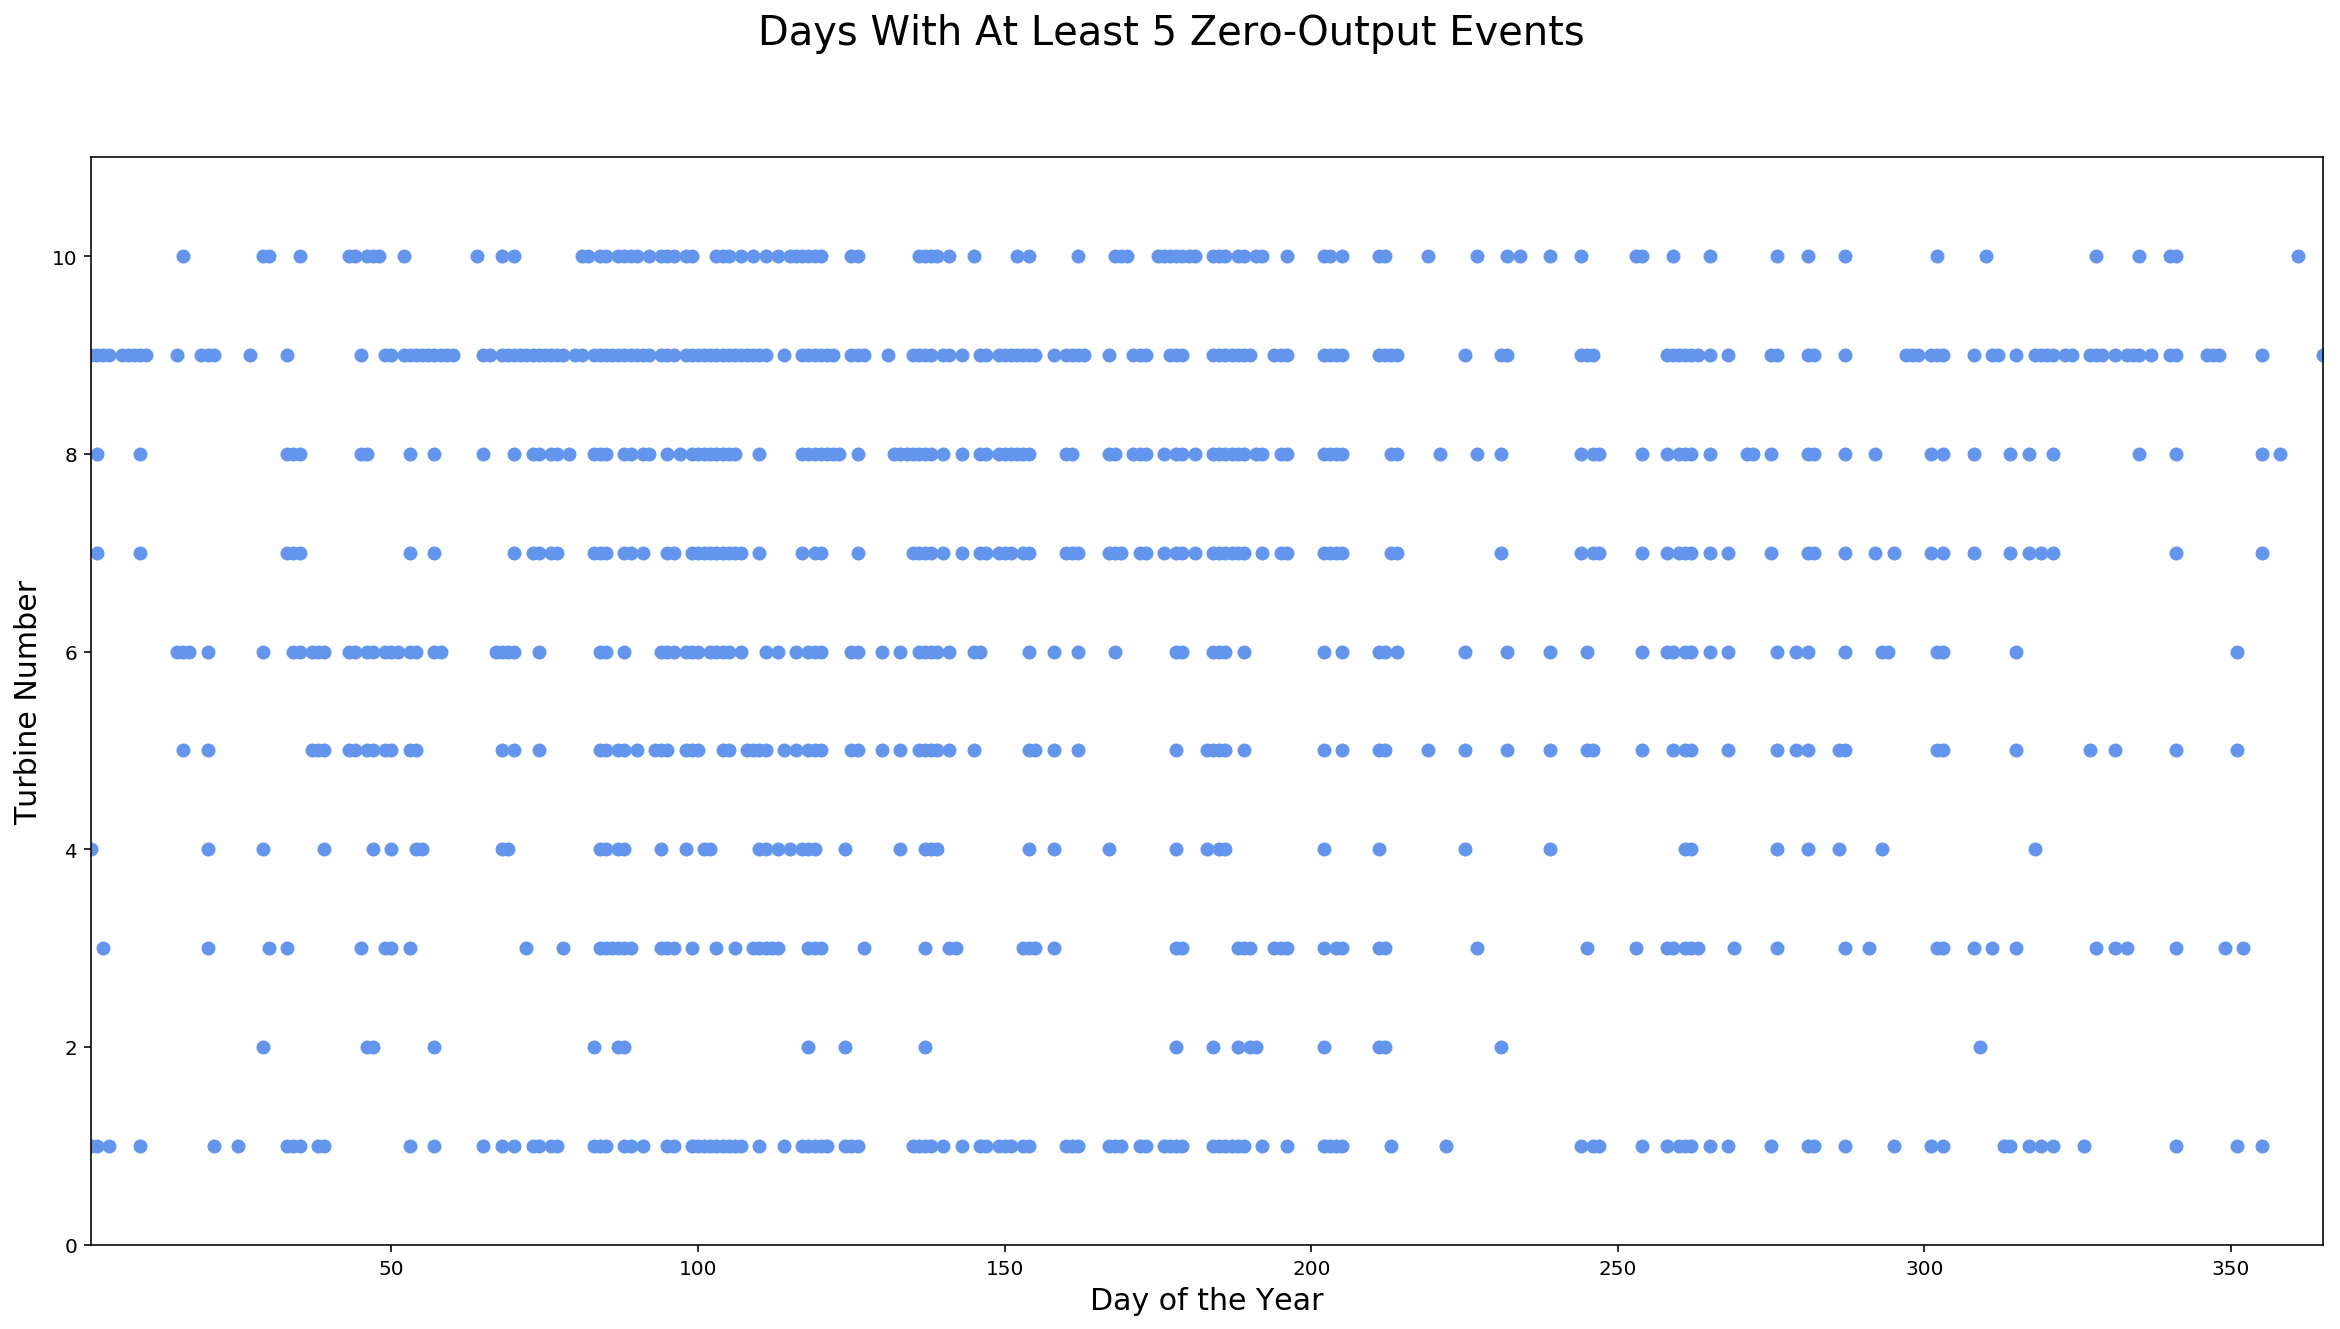

In [7]:
'''
Make a plot of zero-output events as a function of the day of the year.
Do zero-output events tend to correlate among turbines?
'''
nevents   = 5
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(20,10))
plt.suptitle("Days With At Least "+str(nevents)+" Zero-Output Events", fontsize=20)
for turbine in range(1,nturbines+1):
    zero_events = df['DAYOFYEAR'][df[('TARGETVAR',turbine)]==0.0].tolist()
    event_cnts  = {i: zero_events.count(i) for i in range(1,366)}
    xval        = [i for i in range(1,366) if event_cnts[i]>=nevents]
    yval        = [turbine]*len(xval)
    axes.scatter(xval, yval, color="cornflowerblue", alpha=1.0, marker="o")
axes.set_xlabel("Day of the Year", fontsize=15)
axes.set_ylabel("Turbine Number", fontsize=15)
axes.set_xlim([1., 365.])
axes.set_ylim([0., nturbines+1])
plt.show()

<a id='Cell8'></a>

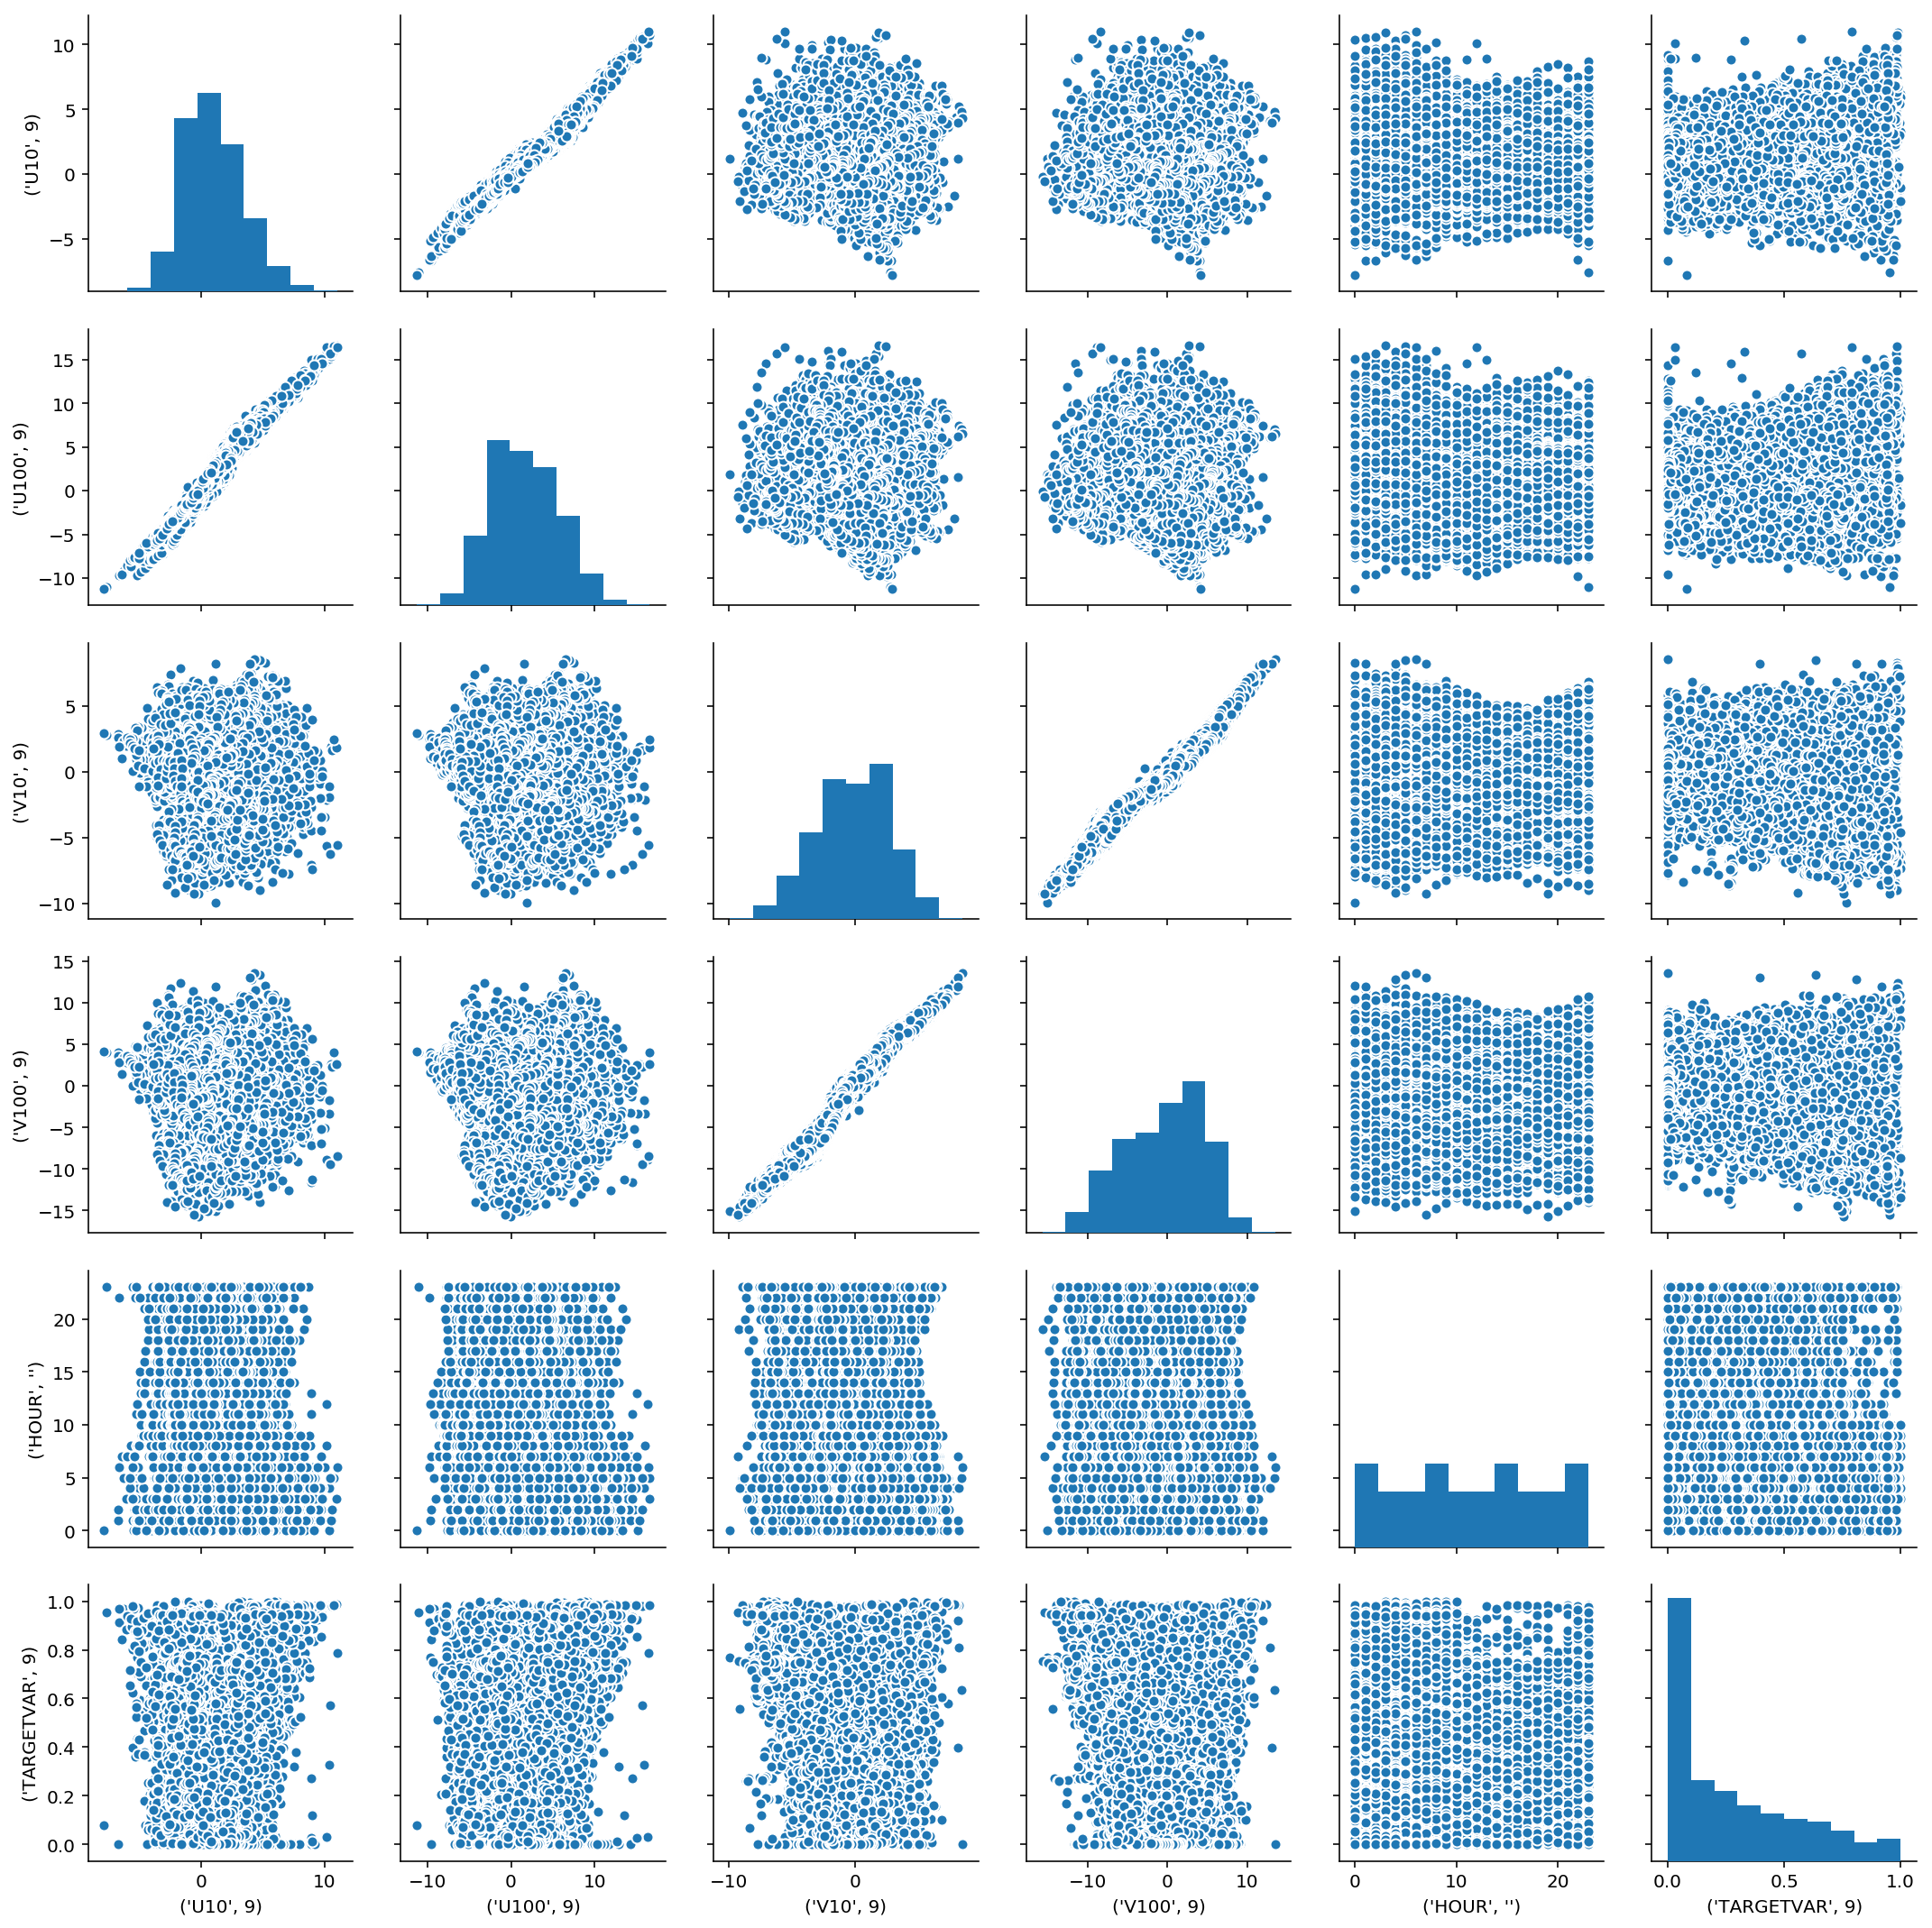

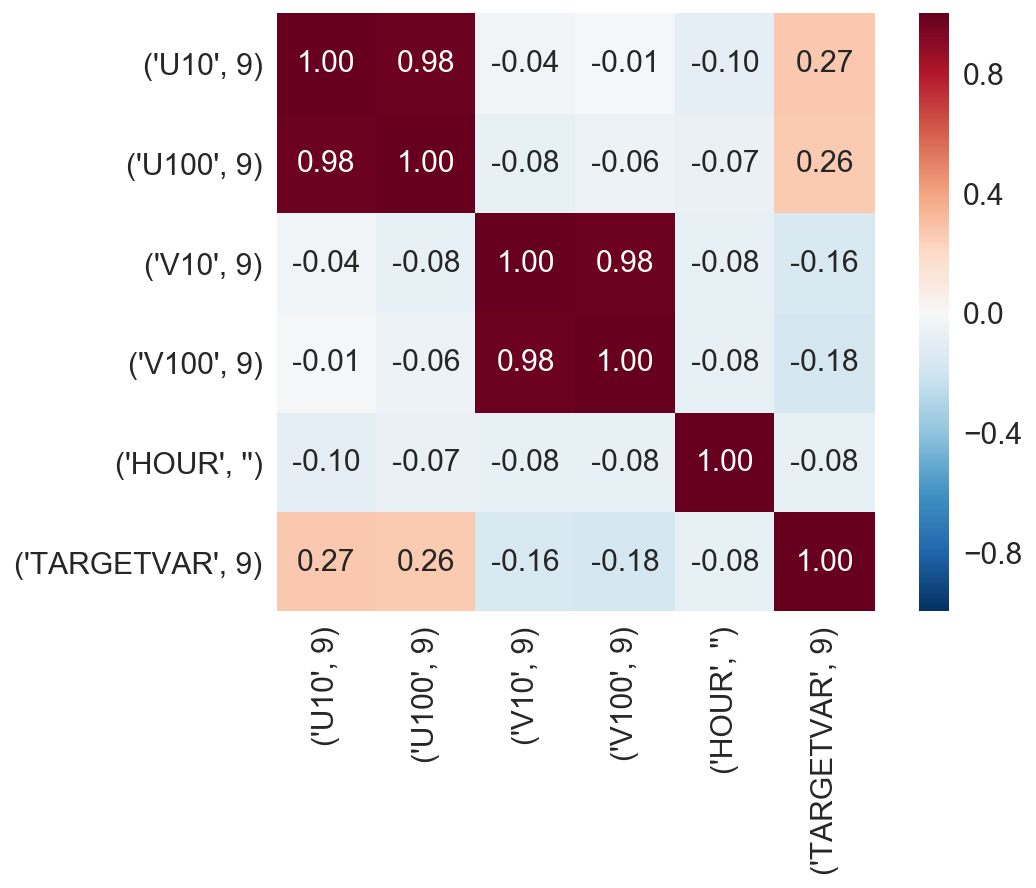

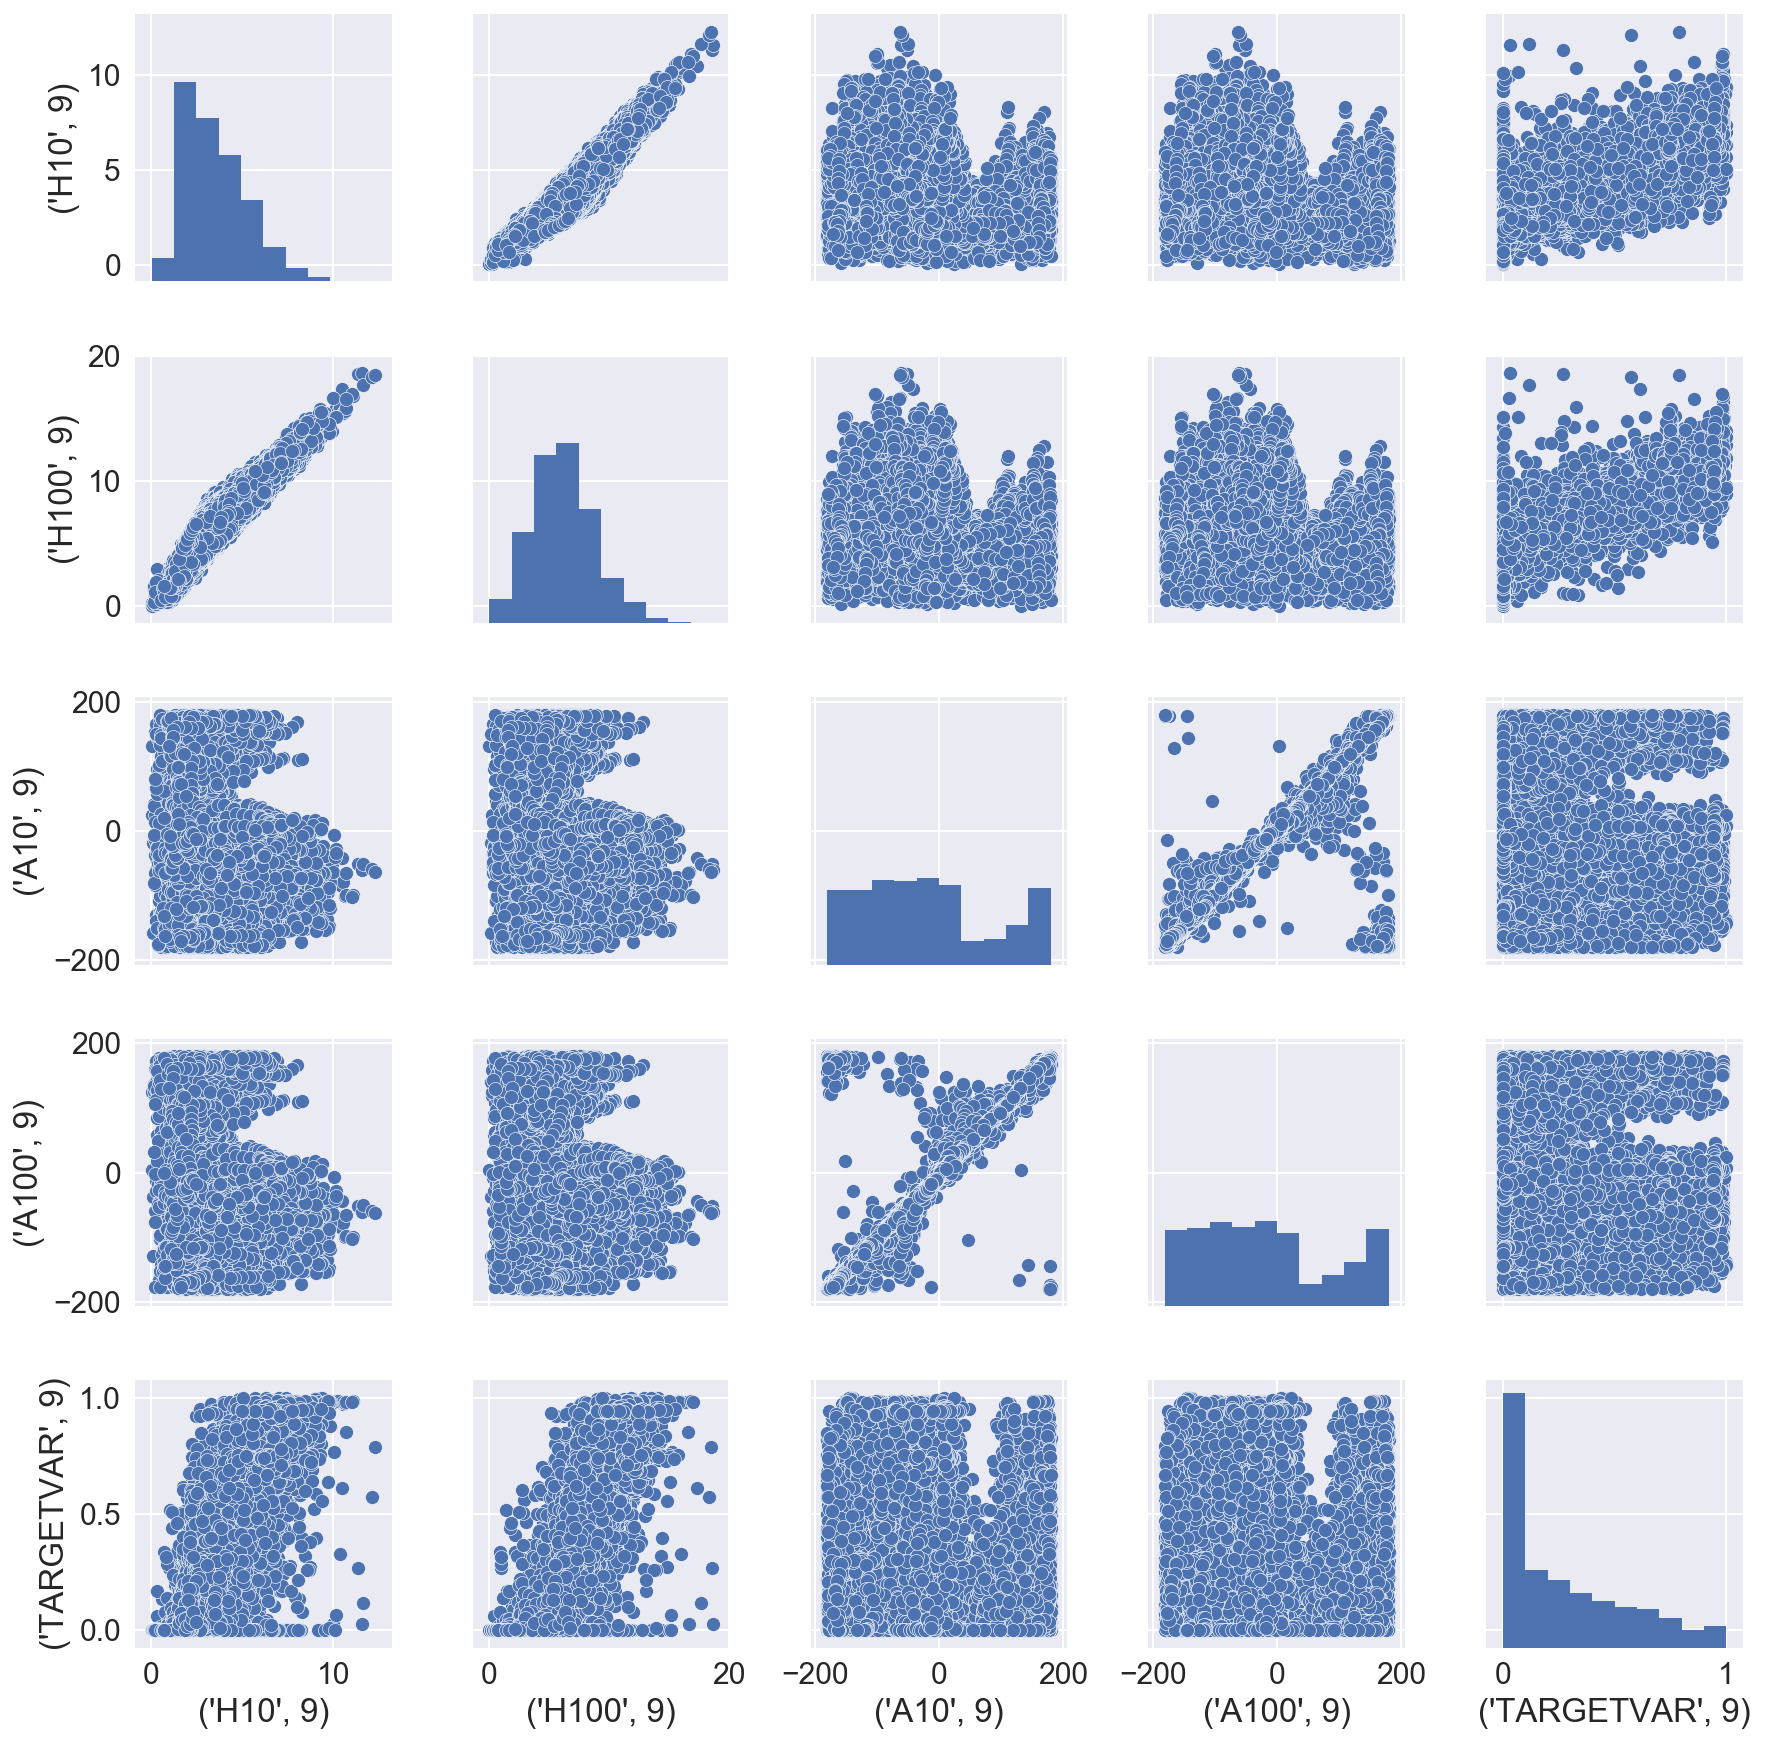

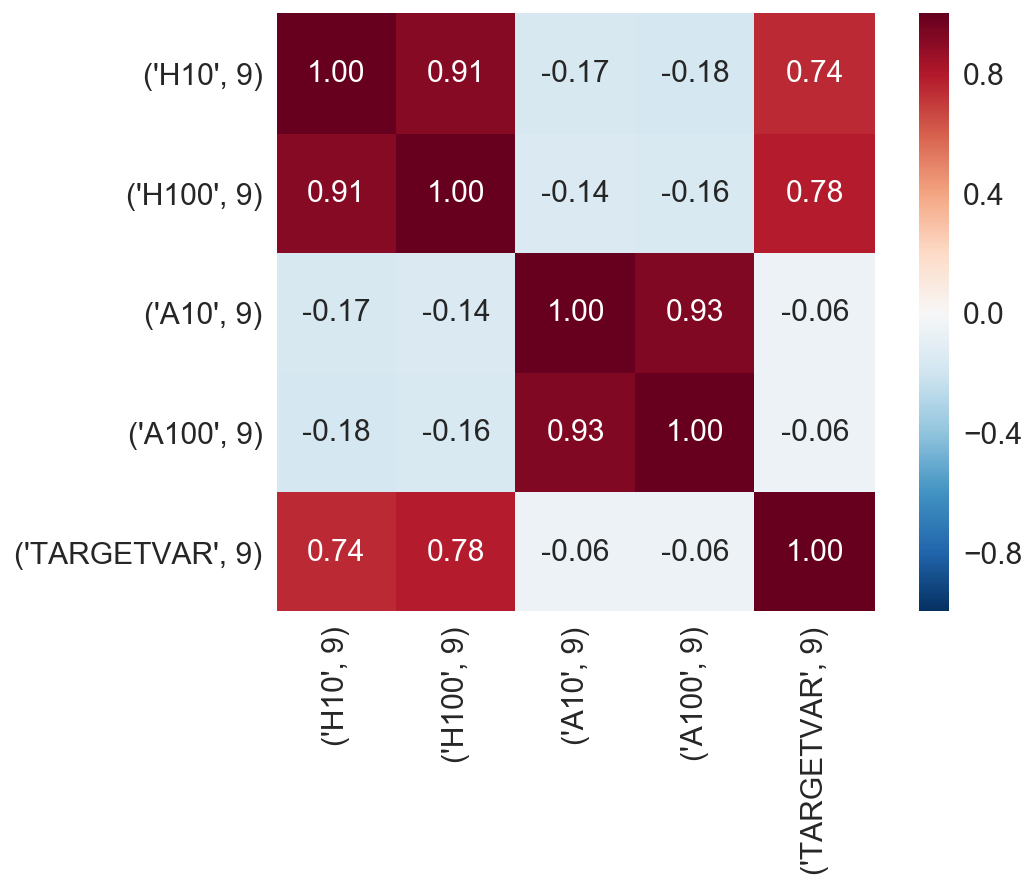

In [20]:
'''
Compute matrix of correlation plots between select features and target variable.
'''

# Scatter plot matrix for wind speed components
#sns.set(style='whitegrid', context='notebook')
turbine = 9
cols = [('U10',turbine), ('U100',turbine), ('V10',turbine), ('V100',turbine), ('HOUR',''), ('TARGETVAR',turbine)]
sns.pairplot(df[cols], size=2.5)
plt.show()

# Correlation matrix
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=cols, xticklabels=cols)
plt.show()

# Scatter plot matrix for wind speed magnitudes and directions
cols = [('H10',turbine), ('H100',turbine), ('A10',turbine), ('A100',turbine), ('TARGETVAR',turbine)]
sns.pairplot(df[cols], size=2.5)
plt.show()

# Correlation matrix
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=cols, xticklabels=cols)
plt.show()

# Reset matplotlib style settings
sns.reset_orig()
import matplotlib.pyplot as plt
%matplotlib inline

<a id='Cell9'></a>

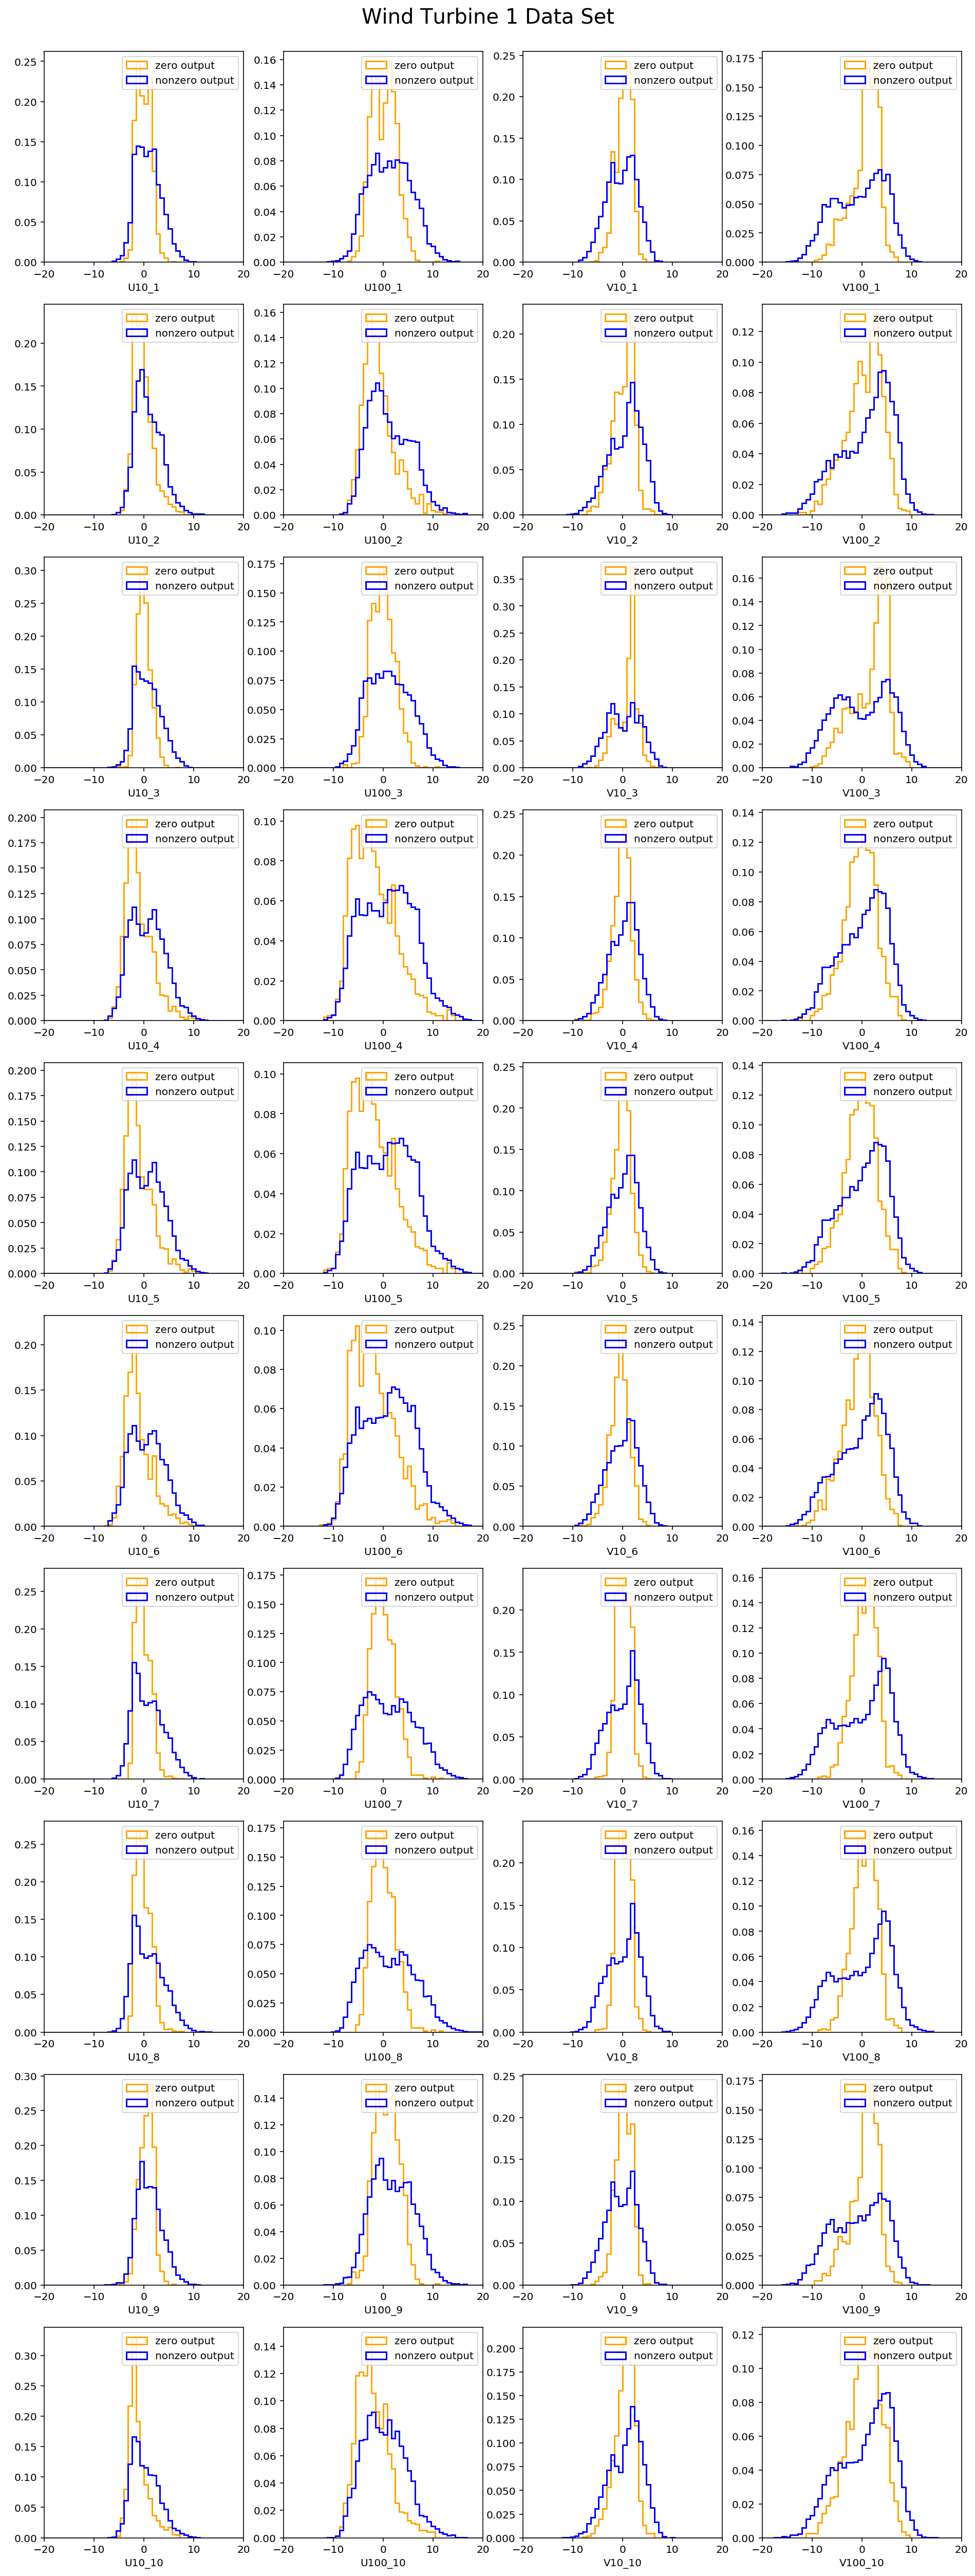

In [4]:
'''
The turbine outputs all have an unusually high spike at zero. Are these unpredictable
breakdown or maintenance events? Or do they correlate with weak winds? Let's see what
we can learn by making plots of feature distributions within the zero-output and 
nonzero-output subsamples.
'''

# Create separate data frames for zero and nonzero target variables
turbine     = 1
df_zero    = df[df[('TARGETVAR',turbine)]==0.0]
df_nonzero = df[df[('TARGETVAR',turbine)]>0.0]

fig, axes = plt.subplots( nrows=10, ncols=4, figsize=(16,40) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.965 )
plt.suptitle("Wind Turbine "+str(turbine)+" Data Set", fontsize=20)
Ycol = ["orange"]
Ncol = ["blue"]
hlw  = 1.5
for turb in range(1,nturbines+1):
    i = turb-1
    axes[i,0].hist(df_zero[('U10',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
    axes[i,0].hist(df_nonzero[('U10',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
    axes[i,0].set_xlabel("U10_"+str(turb))
    axes[i,0].set_xlim(-20., 20.)
    axes[i,0].get_xaxis().get_major_formatter().set_useOffset(False)
    axes[i,0].legend(prop={'size': 10},loc="upper right")

    axes[i,1].hist(df_zero[('U100',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
    axes[i,1].hist(df_nonzero[('U100',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
    axes[i,1].set_xlabel("U100_"+str(turb))
    axes[i,1].set_xlim(-20., 20.)
    axes[i,1].get_xaxis().get_major_formatter().set_useOffset(False)
    axes[i,1].legend(prop={'size': 10},loc="upper right")

    axes[i,2].hist(df_zero[('V10',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
    axes[i,2].hist(df_nonzero[('V10',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
    axes[i,2].set_xlabel("V10_"+str(turb))
    axes[i,2].set_xlim(-20., 20.)
    axes[i,2].get_xaxis().get_major_formatter().set_useOffset(False)
    axes[i,2].legend(prop={'size': 10},loc="upper right")

    axes[i,3].hist(df_zero[('V100',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
    axes[i,3].hist(df_nonzero[('V100',turb)], bins=50, range=[-20.,20.], align="mid",
                   color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
    axes[i,3].set_xlabel("V100_"+str(turb))
    axes[i,3].set_xlim(-20., 20.)
    axes[i,3].get_xaxis().get_major_formatter().set_useOffset(False)
    axes[i,3].legend(prop={'size': 10},loc="upper right")

plt.show()

<a id='Cell10'></a>

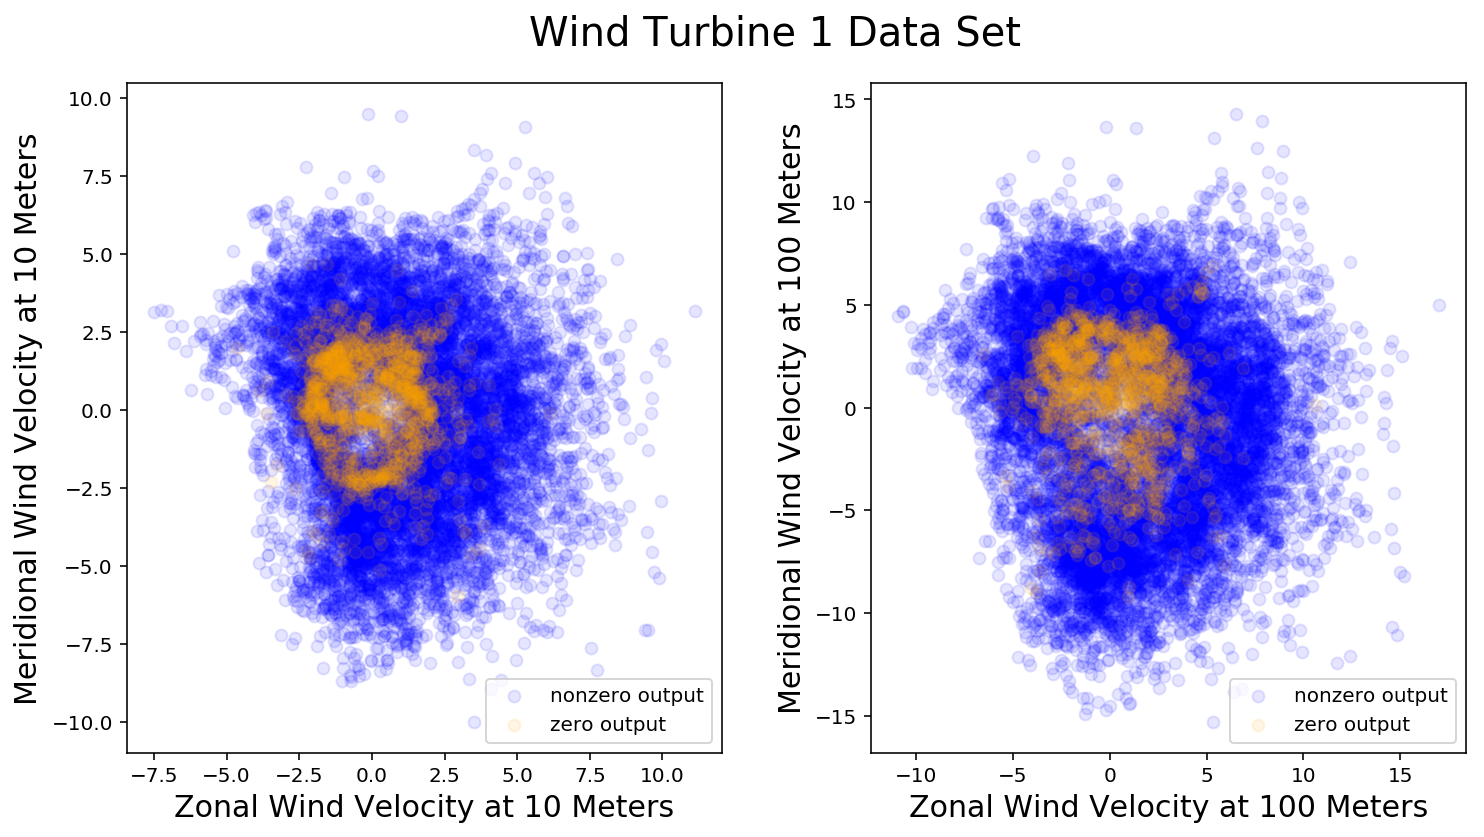

In [5]:
'''
Plot meridional versus zonal wind velocities, separating instances with zero and non-zero turbine output.
'''

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
plt.subplots_adjust( wspace=0.25, hspace=0.15, top=0.90 )
plt.suptitle("Wind Turbine "+str(turbine)+" Data Set", fontsize=20)
Ycol = ["orange"]
Ncol = ["blue"]
alphas = 0.10

axes[0].scatter(df_nonzero[('U10',turbine)], df_nonzero[('V10',turbine)], color=Ncol, alpha=alphas, 
                  marker="o", label="nonzero output")
axes[0].scatter(df_zero[('U10',turbine)], df_zero[('V10',turbine)], color=Ycol, alpha=alphas, 
                  marker="o", label="zero output")
axes[0].set_xlabel("Zonal Wind Velocity at 10 Meters", fontsize=15)
axes[0].set_ylabel("Meridional Wind Velocity at 10 Meters", fontsize=15)
axes[0].legend(prop={'size': 10},loc="lower right")

axes[1].scatter(df_nonzero[('U100',turbine)], df_nonzero[('V100',turbine)], color=Ncol, alpha=alphas, 
                  marker="o", label="nonzero output")
axes[1].scatter(df_zero[('U100',turbine)], df_zero[('V100',turbine)], color=Ycol, alpha=alphas, 
                  marker="o", label="zero output")
axes[1].set_xlabel("Zonal Wind Velocity at 100 Meters", fontsize=15)
axes[1].set_ylabel("Meridional Wind Velocity at 100 Meters", fontsize=15)
axes[1].legend(prop={'size': 10},loc="lower right")

plt.show()
fig.savefig('donut_plots.png', dpi=200, bbox_inches='tight')

<a id='Cell11'></a>

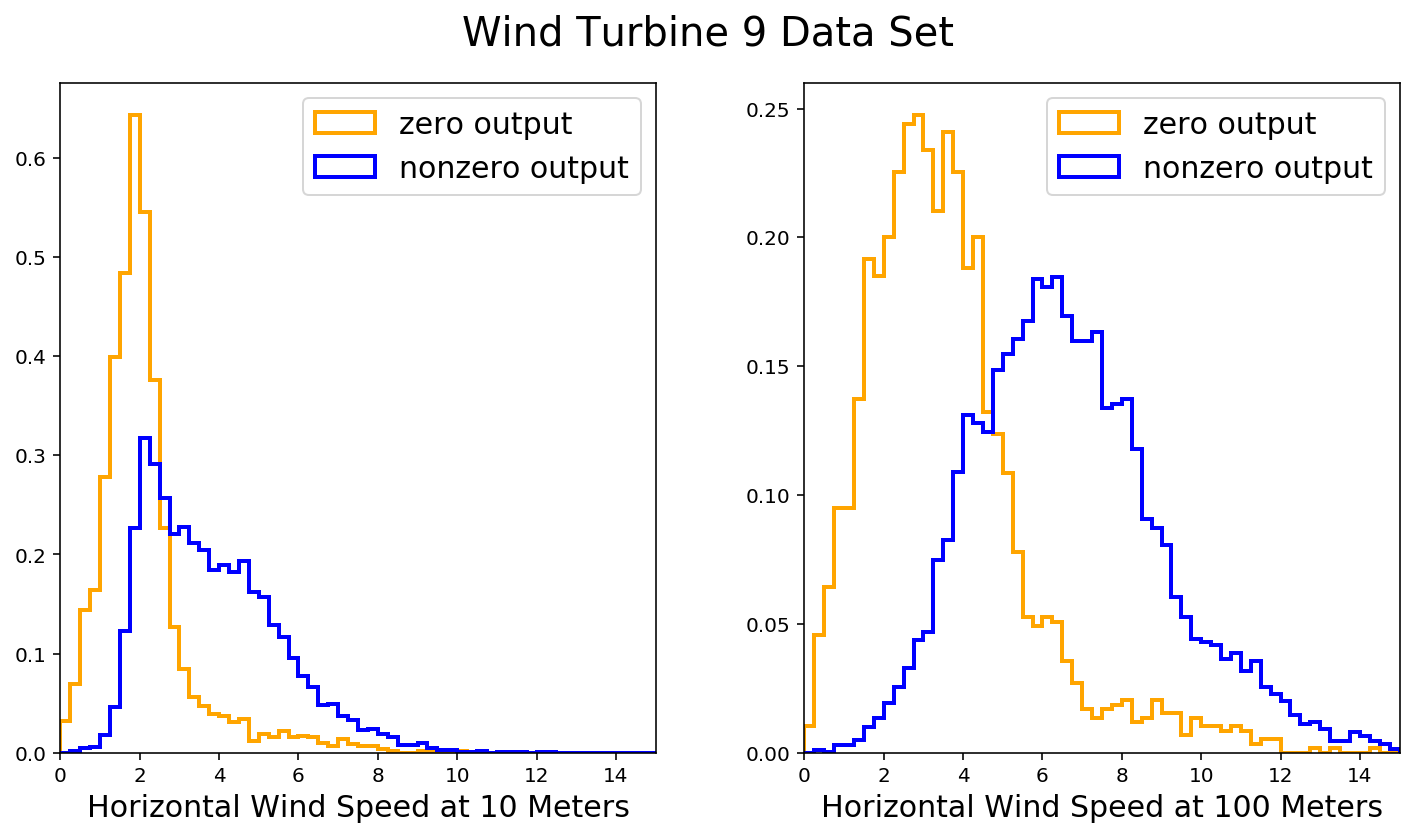

In [35]:
'''
Plot horizontal wind velocity distributions, separately for instances with zero and non-zero turbine output.
'''

fig, axes = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
plt.subplots_adjust( wspace=0.25, hspace=0.15, top=0.90 )
plt.suptitle("Wind Turbine "+str(turbine)+" Data Set", fontsize=20)
Ycol = ["orange"]
Ncol = ["blue"]
alphas = 0.10
hlw = 2.0
axes[0].hist(df_zero[('H10',turbine)], bins=60, range=[0.,15.],
               align="mid", color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
axes[0].hist(df_nonzero[('H10',turbine)], bins=60, range=[0.,15.],
               align="mid", color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
axes[0].set_xlabel("Horizontal Wind Speed at 10 Meters", fontsize=15)
axes[0].set_xlim(0., 15.)
axes[0].legend(prop={'size': 15}, loc="upper right")

axes[1].hist(df_zero[('H100',turbine)], bins=60, range=[0.,15.],
               align="mid", color=Ycol, linewidth=hlw, histtype="step", label="zero output", normed=True)
axes[1].hist(df_nonzero[('H100',turbine)], bins=60, range=[0.,15.],
               align="mid", color=Ncol, linewidth=hlw, histtype="step", label="nonzero output", normed=True)
axes[1].set_xlabel("Horizontal Wind Speed at 100 Meters", fontsize=15)
axes[1].set_xlim(0., 15.)
axes[1].legend(prop={'size': 15}, loc="upper right")

plt.show()